# Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import PowerTransformer

from yellowbrick.regressor import (
    ResidualsPlot,
    PredictionError,
)

from yellowbrick.model_selection import ValidationCurve

from yellowbrick.classifier import ConfusionMatrix

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    StratifiedKFold,
)

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    median_absolute_error,
    mean_squared_error,
    confusion_matrix,
    balanced_accuracy_score,
    precision_score,
    f1_score,
    recall_score,
)

from sklearn.ensemble import (
    IsolationForest,
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_predict,
    cross_val_score,
    StratifiedKFold
)

from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import ElasticNetCV

from sklearn.svm import (
    LinearSVR,
    SVR,
)

from sklearn.neural_network import MLPRegressor

from sklearn.tree import DecisionTreeRegressor

from scipy import stats

# Bancos de dados

## Carregando o banco de dados principal

In [2]:
tiete = pd.read_csv('tiete.csv', sep=';')
tiete.head()

,Unnamed: 0,ugrhi,economia,ponto,ph,od,dbo,cf,nt,pt,res,turb,temp,iqa,classificacao
0,0,5,Industrial,CPIV02200,6.6,2.0,5,110000,4.27,0.419,277,96,23.0,29,RUIM
1,1,5,Industrial,CPIV02200,6.9,0.8,36,900000,7.24,1.160,669,210,23.0,14,PESSIMA
2,2,5,Industrial,CPIV02200,7.1,2.0,14,110000,6.35,0.455,261,72,22.0,27,RUIM
3,3,5,Industrial,CPIV02200,7.4,0.6,16,210000,13.62,1.250,272,46,16.0,20,RUIM
4,4,5,Industrial,CPIV02200,7.0,0.8,24,1700000,24.82,3.200,559,60,22.0,16,PESSIMA


### Removendo os Nans

In [3]:
tiete.isna().sum()

Unnamed: 0       0
ugrhi            0
economia         0
ponto            0
ph               0
od               0
dbo              0
cf               0
nt               0
pt               0
res              0
turb             0
temp             0
iqa              0
classificacao    0
dtype: int64

## Limpando o banco de dados

### Bancos de dados com outliers X e y_train

In [4]:
X_ = tiete.drop(columns=['Unnamed: 0', 'ugrhi', 'economia', 'ponto', 'iqa', 'classificacao'], axis=1).copy()
X_ = X_.rename(columns={'od': 'do', 'dbo':'bod', 'cf':'tc', 'nt':'tn', 'pt':'tp', 'res':'ts'})
X_.head()

,ph,do,bod,tc,tn,tp,ts,turb,temp
0,6.6,2.0,5,110000,4.27,0.419,277,96,23.0
1,6.9,0.8,36,900000,7.24,1.160,669,210,23.0
2,7.1,2.0,14,110000,6.35,0.455,261,72,22.0
3,7.4,0.6,16,210000,13.62,1.250,272,46,16.0
4,7.0,0.8,24,1700000,24.82,3.200,559,60,22.0


In [5]:
y_ = tiete['iqa'].copy()
y_.head()

0    29
1    14
2    27
3    20
4    16
Name: iqa, dtype: int64

In [6]:
tiete_out = pd.concat([X_,y_], axis=1)
tiete_out.shape

(7101, 10)

### Removendo outliers

In [7]:
clf = IsolationForest(random_state=42)
outliers = clf.fit_predict(X_);

In [8]:
tiete_out['outliers'] = np.transpose(outliers)
tiete_cleaned = tiete_out[tiete_out['outliers']==1].copy()
tiete_cleaned.head(2)

,ph,do,bod,tc,tn,tp,ts,turb,temp,iqa,outliers
0,6.6,2.0,5,110000,4.27,0.419,277,96,23.0,29,1
2,7.1,2.0,14,110000,6.35,0.455,261,72,22.0,27,1


In [9]:
X_cleaned = tiete_cleaned.drop(columns=['iqa', 'outliers'], axis=1)
y_cleaned = tiete_cleaned['iqa']

In [10]:
tiete = tiete_cleaned.drop(columns=['outliers'], axis=1).copy()
tiete.head(2)

,ph,do,bod,tc,tn,tp,ts,turb,temp,iqa
0,6.6,2.0,5,110000,4.27,0.419,277,96,23.0,29
2,7.1,2.0,14,110000,6.35,0.455,261,72,22.0,27


In [11]:
tiete.shape

(6545, 10)

In [14]:
tiete.describe()

,ph,do,bod,tc,tn,tp,ts,turb,temp,iqa
count,6545.000000,6545.000000,6545.000000,6.545000e+03,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000
mean,7.175676,4.155801,15.443545,6.552634e+05,7.738594,0.605910,215.202750,29.086631,23.019328,48.185943
std,0.468547,2.870922,20.410463,1.636620e+06,7.819622,0.789062,122.428547,36.568562,3.292072,24.721822
min,4.500000,0.000000,0.000000,0.000000e+00,0.130000,0.002000,1.000000,0.000000,13.000000,11.000000
25%,6.900000,1.300000,2.000000,1.670000e+02,1.520000,0.050000,114.000000,8.000000,20.600000,25.000000
50%,7.100000,4.300000,6.000000,6.167000e+03,4.680000,0.244000,188.000000,18.000000,23.100000,46.000000
75%,7.400000,6.680000,20.000000,3.666670e+05,12.200000,0.900000,294.000000,35.000000,25.400000,71.000000
max,9.600000,16.800000,210.000000,2.500000e+07,69.270000,13.000000,978.000000,330.000000,35.000000,94.000000


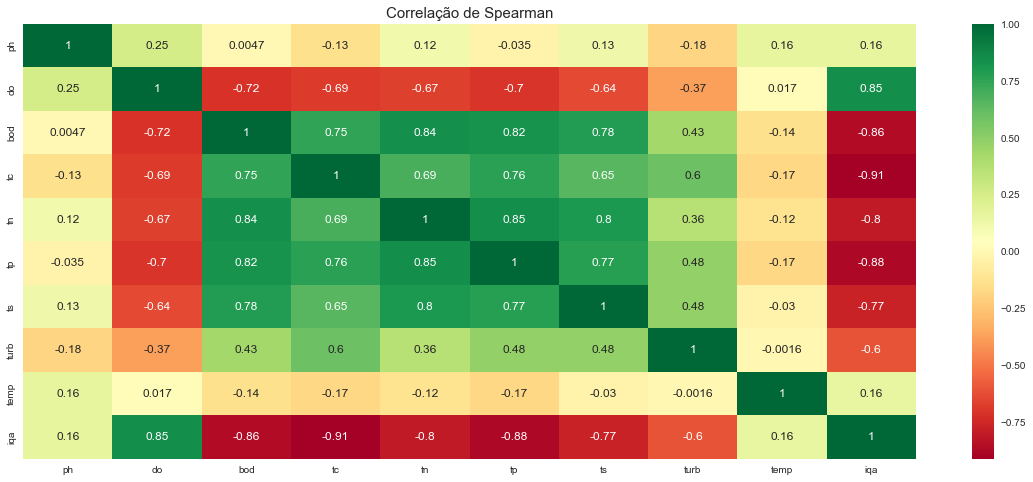

In [16]:
plt.figure(figsize=(20,8))
plt.title('Spearmans rank correlation coefficient',size=15)
sns.heatmap(tiete.corr('spearman'), annot = True, cmap= "RdYlGn");

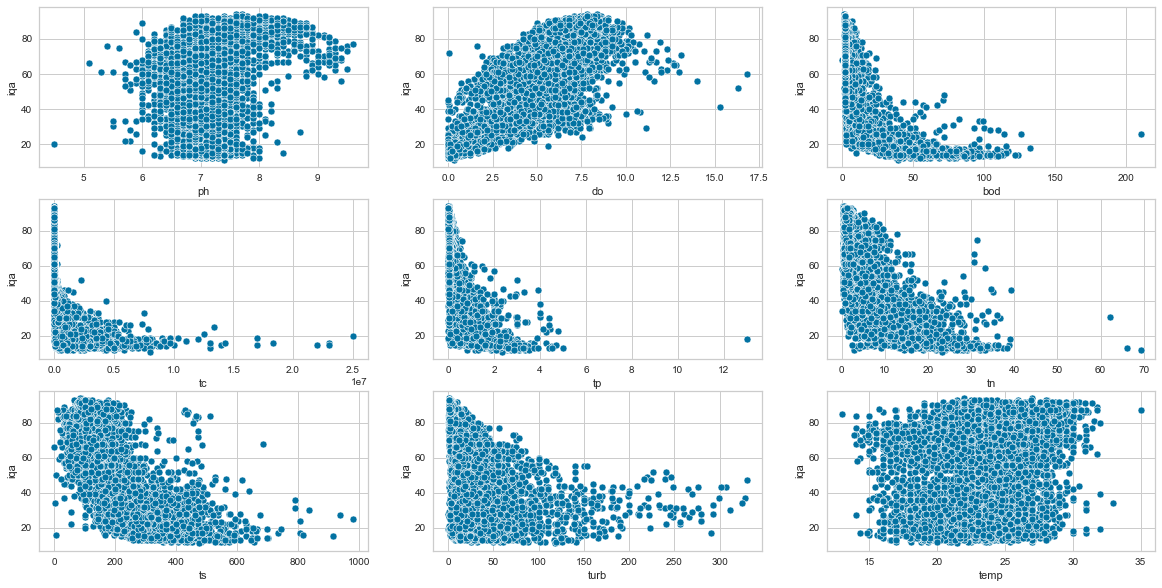

In [17]:
fig,ax = plt.subplots(3,3, figsize=(20,10))
sns.scatterplot(x='ph', y='iqa', data = tiete, ax=ax[0][0]);
sns.scatterplot(x='do', y='iqa', data = tiete, ax=ax[0][1]);
sns.scatterplot(x='bod', y='iqa', data = tiete, ax=ax[0][2]);
sns.scatterplot(x='tc', y='iqa', data = tiete, ax=ax[1][0]);
sns.scatterplot(x='tp', y='iqa', data = tiete, ax=ax[1][1]);
sns.scatterplot(x='tn', y='iqa', data = tiete, ax=ax[1][2]);
sns.scatterplot(x='ts', y='iqa', data = tiete, ax=ax[2][0]);
sns.scatterplot(x='turb', y='iqa', data = tiete, ax=ax[2][1]);
sns.scatterplot(x='temp', y='iqa', data = tiete, ax=ax[2][2]);

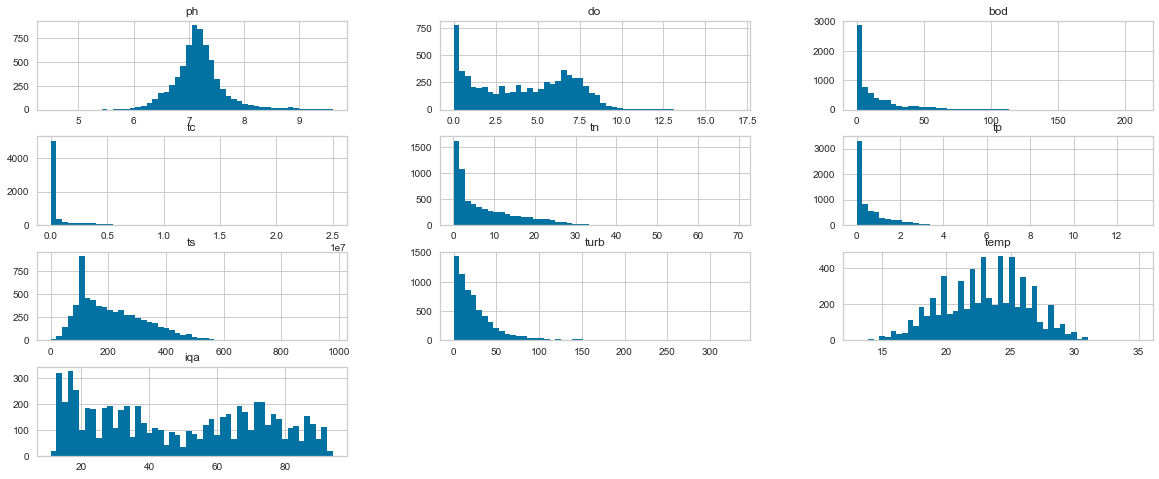

In [18]:
tiete.hist(figsize=(20,8), bins=50);

## Dataframe de Validacao

In [19]:
data = pd.read_csv('dados_bruto.csv', sep=';')
data = data.dropna().copy()
data = data[['ph', 'od', 'dbo', 'cf', 'nt', 'pt', 'res', 'turb', 'temp', 'iqa', 'classificacao']]
data = data.rename(columns={'od': 'do', 'dbo':'bod', 'cf':'tc', 'nt':'tn', 'pt':'tp', 'res':'ts'})
data.head()

,ph,do,bod,tc,tn,tp,ts,turb,temp,iqa,classificacao
0,7.0,7.4,3.0,1767.0,9.50,0.03,50.0,20.0,20.0,66.0,BOA
1,7.1,6.7,3.0,88333.0,4.10,0.09,50.0,22.0,20.0,52.0,BOA
2,7.1,6.4,3.0,75000.0,11.62,0.07,50.0,39.0,20.0,49.0,REGULAR
3,7.2,7.3,3.0,6500.0,1.91,0.04,50.0,19.0,20.0,64.0,BOA
4,7.0,7.9,3.0,540.0,4.10,0.04,50.0,26.0,23.0,70.0,BOA


In [20]:
X_val = data.drop(columns=['iqa', 'classificacao']).copy()
y_val = data['iqa'].copy()

## Split train and test & scaler

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

In [22]:
scaler = PowerTransformer()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [23]:
cols = X_train.columns
X_train_scaled = pd.DataFrame(X_train_scaled, columns=cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=cols)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=cols)

# Regressions

In [24]:
cvs = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

### KNeighbors Regressor

In [25]:
knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)
knn_p = knn.predict(X_train_scaled)

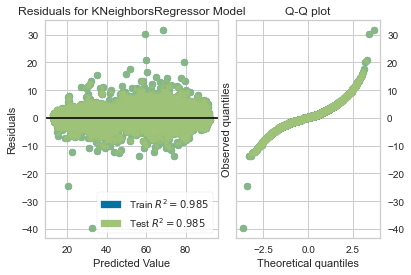

In [26]:
fig, ax = plt.subplots(figsize=(6, 4))
rpv = ResidualsPlot(knn, hist=False, qqplot=True)
rpv.fit(X_train_scaled, y_train)
rpv.score(X_train_scaled, y_train)
rpv.poof();

In [27]:
resids = y_train - knn.predict(X_train_scaled)
hb = sms.het_breuschpagan(resids, X_train_scaled)
labels = [
    "Lagrange multiplier statistic",
    "p-value",
    "f-value",
    "f p-value",
]
for name, num in zip(labels, hb):
    print(f"{name}: {num:.2}")

Lagrange multiplier statistic: 7.6e+01
p-value: 2.6e-13
f-value: 8.6
f p-value: 6.8e-13


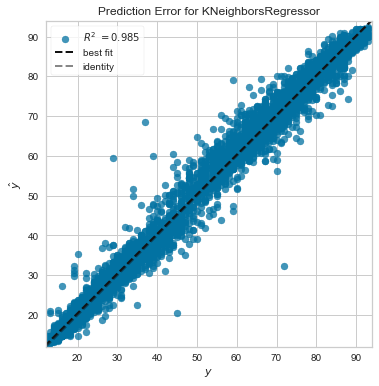

In [28]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(knn)
pev.fit(X_train_scaled, y_train)
pev.score(X_train_scaled, y_train)
pev.poof();

In [29]:
r2 = r2_score(y_train, knn_p)
mse = mean_squared_error(y_train, knn_p)
rmse = mean_squared_error(y_train, knn_p, squared=False)
mae = mean_absolute_error(y_train, knn_p)
medae = median_absolute_error(y_train, knn_p)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}')  

R²: 0.985
MSE: 9.084
RMSE: 3.014
MAE: 2.011
MedAE: 1.400


In [30]:
r2 = cross_val_score(knn, X_train_scaled, y_train, cv=cvs, scoring='r2')
mse = -cross_val_score(knn, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_squared_error')
rmse = -cross_val_score(knn, X_train_scaled, y_train, cv=cvs, scoring='neg_root_mean_squared_error')
mae = -cross_val_score(knn, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_absolute_error')
medae = -cross_val_score(knn, X_train_scaled, y_train, cv=cvs, scoring='neg_median_absolute_error')

print(f'R²: {r2.mean():.3f} +- {r2.std():.3f}')
print(f'MSE: {mse.mean():.3f} +- {mse.std():.3f}')
print(f'RMSE: {rmse.mean():.3f} +- {rmse.std():.3f}')
print(f'MAE: {mae.mean():.3f} +- {mae.std():.3f}')
print(f'MedAE: {medae.mean():.3f} +- {medae.std():.3f}') 

R²: 0.977 +- 0.005
MSE: 13.939 +- 2.835
RMSE: 3.716 +- 0.363
MAE: 2.503 +- 0.145
MedAE: 1.690 +- 0.094


### Avaliação Final do Modelo

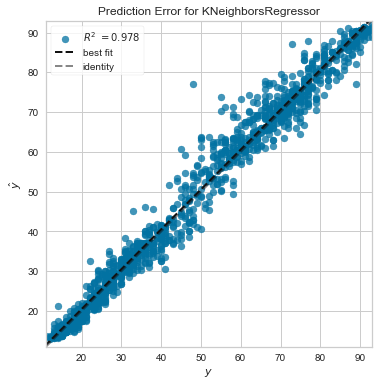

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(knn)
pev.fit(X_train_scaled, y_train)
pev.score(X_test_scaled, y_test)
pev.poof();

In [32]:
pred_knn = knn.predict(X_test_scaled)

In [33]:
r2 = r2_score(y_test, pred_knn)
mse = mean_squared_error(y_test, pred_knn)
rmse = mean_squared_error(y_test, pred_knn, squared=False)
mae = mean_absolute_error(y_test, pred_knn)
medae = median_absolute_error(y_test, pred_knn)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}')      

R²: 0.978
MSE: 12.662
RMSE: 3.558
MAE: 2.403
MedAE: 1.400


### ElasticNet CV

In [34]:
eln = ElasticNetCV(cv=5, random_state=42)
eln.fit(X_train_scaled, y_train)
eln_p = eln.predict(X_train_scaled)

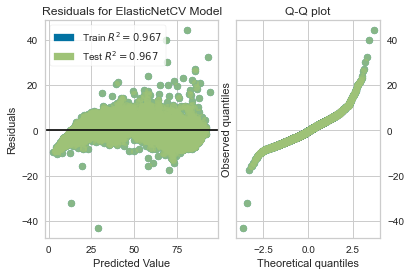

In [35]:
fig, ax = plt.subplots(figsize=(6, 4))
rpv = ResidualsPlot(eln, hist=False, qqplot=True)
rpv.fit(X_train_scaled, y_train)
rpv.score(X_train_scaled, y_train)
rpv.poof();

In [36]:
resids = y_train - eln.predict(X_train_scaled)
hb = sms.het_breuschpagan(resids, X_train_scaled)
labels = [
    "Lagrange multiplier statistic",
    "p-value",
    "f-value",
    "f p-value",
]
for name, num in zip(labels, hb):
    print(f"{name}: {num:.2}")

Lagrange multiplier statistic: 9.1e+01
p-value: 2.7e-16
f-value: 1e+01
f p-value: 6.9e-16


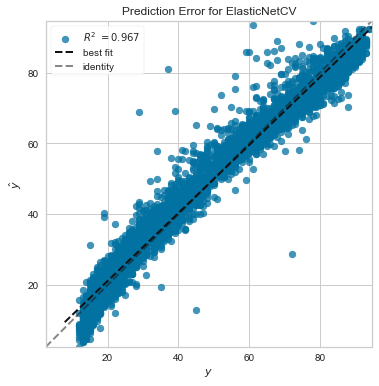

In [37]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(eln)
pev.fit(X_train_scaled, y_train)
pev.score(X_train_scaled, y_train)
pev.poof();

In [38]:
r2 = r2_score(y_train, eln_p)
mse = mean_squared_error(y_train, eln_p)
rmse = mean_squared_error(y_train,eln_p, squared=False)
mae = mean_absolute_error(y_train, eln_p)
medae = median_absolute_error(y_train, eln_p)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}')  

R²: 0.967
MSE: 20.614
RMSE: 4.540
MAE: 3.483
MedAE: 2.964


In [39]:
r2 = cross_val_score(eln, X_train_scaled, y_train, cv=cvs, scoring='r2')
mse = -cross_val_score(eln, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_squared_error')
rmse = -cross_val_score(eln, X_train_scaled, y_train, cv=cvs, scoring='neg_root_mean_squared_error')
mae = -cross_val_score(eln, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_absolute_error')
medae = -cross_val_score(eln, X_train_scaled, y_train, cv=cvs, scoring='neg_median_absolute_error')

print(f'R²: {r2.mean():.3f} +- {r2.std():.3f}')
print(f'MSE: {mse.mean():.3f} +- {mse.std():.3f}')
print(f'RMSE: {rmse.mean():.3f} +- {rmse.std():.3f}')
print(f'MAE: {mae.mean():.3f} +- {mae.std():.3f}')
print(f'MedAE: {medae.mean():.3f} +- {medae.std():.3f}') 

R²: 0.966 +- 0.004
MSE: 20.729 +- 2.625
RMSE: 4.544 +- 0.279
MAE: 3.489 +- 0.071
MedAE: 2.971 +- 0.067


### Avaliação Final do Modelo

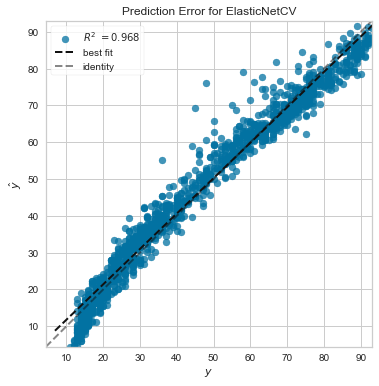

In [40]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(eln)
pev.fit(X_train_scaled, y_train)
pev.score(X_test_scaled, y_test)
pev.poof();

In [41]:
eln.fit(X_train_scaled, y_train)
pred_eln = eln.predict(X_test_scaled)

In [42]:
r2 = r2_score(y_test, pred_eln)
mse = mean_squared_error(y_test, pred_eln)
rmse = mean_squared_error(y_test, pred_eln, squared=False)
mae = mean_absolute_error(y_test, pred_eln)
medae = median_absolute_error(y_test, pred_eln)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}')     

R²: 0.968
MSE: 18.769
RMSE: 4.332
MAE: 3.380
MedAE: 3.000


### Linear SVR

In [43]:
svr_l = LinearSVR(random_state=42)
svr_l.fit(X_train_scaled, y_train)
svr_l_p = svr_l.predict(X_train_scaled)

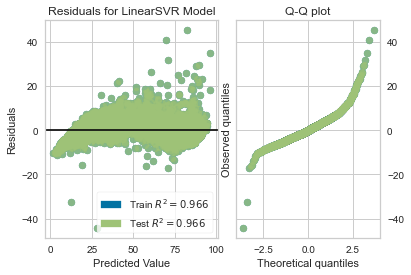

In [44]:
fig, ax = plt.subplots(figsize=(6, 4))
rpv = ResidualsPlot(svr_l, hist=False, qqplot=True)
rpv.fit(X_train_scaled, y_train)
rpv.score(X_train_scaled, y_train)
rpv.poof();

In [45]:
resids = y_train - svr_l.predict(X_train_scaled)
hb = sms.het_breuschpagan(resids, X_train_scaled)
labels = [
    "Lagrange multiplier statistic",
    "p-value",
    "f-value",
    "f p-value",
]
for name, num in zip(labels, hb):
    print(f"{name}: {num:.2}")

Lagrange multiplier statistic: 1.1e+02
p-value: 5.7e-21
f-value: 1.3e+01
f p-value: 1.3e-20


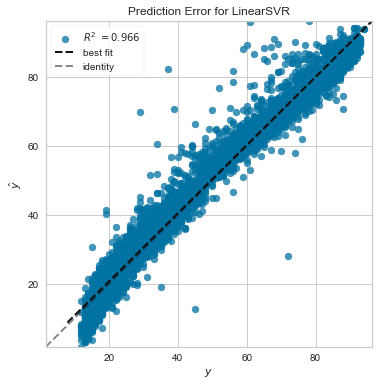

In [46]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(svr_l)
pev.fit(X_train_scaled, y_train)
pev.score(X_train_scaled, y_train)
pev.poof();

In [47]:
r2 = r2_score(y_train, svr_l_p)
mse = mean_squared_error(y_train, svr_l_p)
rmse = mean_squared_error(y_train, svr_l_p, squared=False)
mae = mean_absolute_error(y_train, svr_l_p)
medae = median_absolute_error(y_train, svr_l_p)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}')  

R²: 0.966
MSE: 21.223
RMSE: 4.607
MAE: 3.416
MedAE: 2.749


In [48]:
r2 = cross_val_score(svr_l, X_train_scaled, y_train, cv=cvs, scoring='r2')
mse = -cross_val_score(svr_l, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_squared_error')
rmse = -cross_val_score(svr_l, X_train_scaled, y_train, cv=cvs, scoring='neg_root_mean_squared_error')
mae = -cross_val_score(svr_l, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_absolute_error')
medae = -cross_val_score(svr_l, X_train_scaled, y_train, cv=cvs, scoring='neg_median_absolute_error')

print(f'R²: {r2.mean():.3f} +- {r2.std():.3f}')
print(f'MSE: {mse.mean():.3f} +- {mse.std():.3f}')
print(f'RMSE: {rmse.mean():.3f} +- {rmse.std():.3f}')
print(f'MAE: {mae.mean():.3f} +- {mae.std():.3f}')
print(f'MedAE: {medae.mean():.3f} +- {medae.std():.3f}')

R²: 0.966 +- 0.004
MSE: 21.298 +- 2.811
RMSE: 4.606 +- 0.295
MAE: 3.427 +- 0.082
MedAE: 2.764 +- 0.099


### Avaliação Final do Modelo

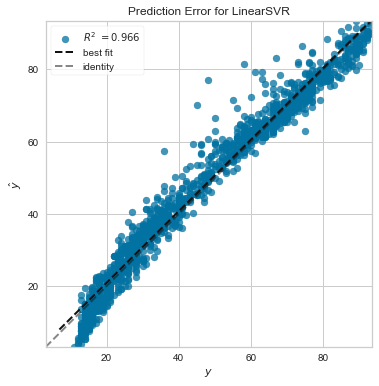

In [49]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(svr_l)
pev.fit(X_train_scaled, y_train)
pev.score(X_test_scaled, y_test)
pev.poof();

In [50]:
pred_svr_l = svr_l.predict(X_test_scaled)

In [51]:
r2 = r2_score(y_test, pred_svr_l)
mse = mean_squared_error(y_test, pred_svr_l)
rmse = mean_squared_error(y_test, pred_svr_l, squared=False)
mae = mean_absolute_error(y_test, pred_svr_l)
medae = median_absolute_error(y_test, pred_svr_l)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}')  

R²: 0.966
MSE: 19.516
RMSE: 4.418
MAE: 3.347
MedAE: 2.789


### SVR

In [52]:
svr = SVR()
svr.fit(X_train_scaled, y_train)
svr_p = svr.predict(X_train_scaled)

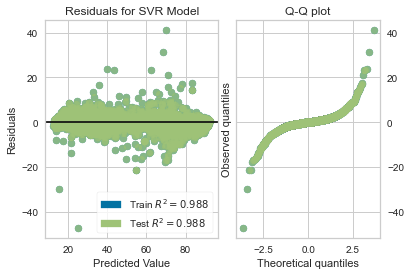

In [53]:
fig, ax = plt.subplots(figsize=(6, 4))
rpv = ResidualsPlot(svr, hist=False, qqplot=True)
rpv.fit(X_train_scaled, y_train)
rpv.score(X_train_scaled, y_train)
rpv.poof();

In [54]:
resids = y_train - svr.predict(X_train_scaled)
hb = sms.het_breuschpagan(resids, X_train_scaled)
labels = [
    "Lagrange multiplier statistic",
    "p-value",
    "f-value",
    "f p-value",
]
for name, num in zip(labels, hb):
    print(f"{name}: {num:.2}")

Lagrange multiplier statistic: 5.6e+01
p-value: 3.3e-09
f-value: 6.2
f p-value: 8.1e-09


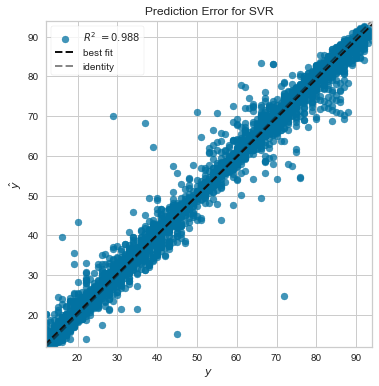

In [55]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(svr)
pev.fit(X_train_scaled, y_train)
pev.score(X_train_scaled, y_train)
pev.poof();

In [56]:
r2 = r2_score(y_train, svr_p)
mse = mean_squared_error(y_train, svr_p)
rmse = mean_squared_error(y_train, svr_p, squared=False)
mae = mean_absolute_error(y_train, svr_p)
medae = median_absolute_error(y_train, svr_p)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}')  

R²: 0.988
MSE: 7.504
RMSE: 2.739
MAE: 1.516
MedAE: 0.872


### Ajuste do SVR

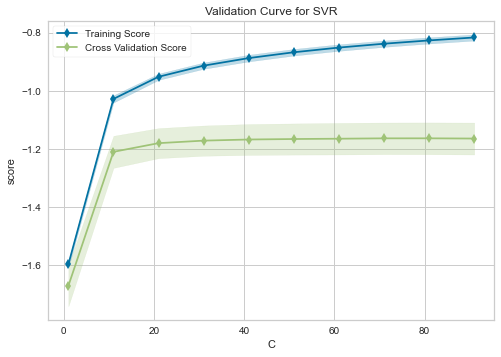

In [57]:
viz = ValidationCurve(
    SVR(), 
    param_name='C',
    param_range=np.arange(1.0, 101.0, 10.0, dtype=float), 
    cv=5, 
    scoring='neg_mean_absolute_error'
)

viz.fit(X_train_scaled, y_train)
viz.show();

In [58]:
svr_best = SVR(C=20)
svr_best.fit(X_train_scaled, y_train)
svr_p = svr_best.predict(X_train_scaled)

In [59]:
r2 = r2_score(y_train, svr_p)
mse = mean_squared_error(y_train, svr_p)
rmse = mean_squared_error(y_train, svr_p, squared=False)
mae = mean_absolute_error(y_train, svr_p)
medae = median_absolute_error(y_train, svr_p)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}')  

R²: 0.992
MSE: 4.819
RMSE: 2.195
MAE: 0.963
MedAE: 0.476


In [60]:
r2 = cross_val_score(svr_best, X_train_scaled, y_train, cv=cvs, scoring='r2')
mse = -cross_val_score(svr_best, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_squared_error')
rmse = -cross_val_score(svr_best, X_train_scaled, y_train, cv=cvs, scoring='neg_root_mean_squared_error')
mae = -cross_val_score(svr_best, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_absolute_error')
medae = -cross_val_score(svr_best, X_train_scaled, y_train, cv=cvs, scoring='neg_median_absolute_error')

print(f'R²: {r2.mean():.3f} +- {r2.std():.3f}')
print(f'MSE: {mse.mean():.3f} +- {mse.std():.3f}')
print(f'RMSE: {rmse.mean():.3f} +- {rmse.std():.3f}')
print(f'MAE: {mae.mean():.3f} +- {mae.std():.3f}')
print(f'MedAE: {medae.mean():.3f} +- {medae.std():.3f}') 

R²: 0.991 +- 0.004
MSE: 5.847 +- 2.459
RMSE: 2.373 +- 0.464
MAE: 1.171 +- 0.086
MedAE: 0.644 +- 0.031


### Avaliação Final do Modelo

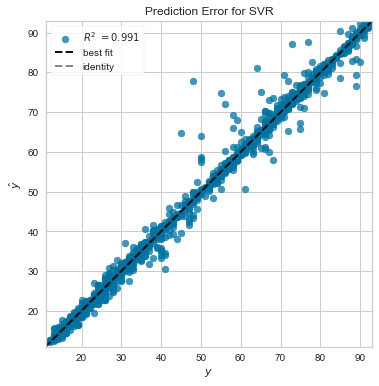

In [61]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(svr_best)
pev.fit(X_train_scaled, y_train)
pev.score(X_test_scaled, y_test)
pev.poof();

In [62]:
pred_svr = svr_best.predict(X_test_scaled)

In [63]:
r2 = r2_score(y_test, pred_svr)
mse = mean_squared_error(y_test, pred_svr)
rmse = mean_squared_error(y_test, pred_svr, squared=False)
mae = mean_absolute_error(y_test, pred_svr)
medae = median_absolute_error(y_test, pred_svr)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}')  

R²: 0.991
MSE: 5.145
RMSE: 2.268
MAE: 1.142
MedAE: 0.625


### MLP Regressor

In [64]:
mlp = MLPRegressor(random_state=42, max_iter=10000)
mlp.fit(X_train_scaled, y_train);
mlp_p = mlp.predict(X_train_scaled)

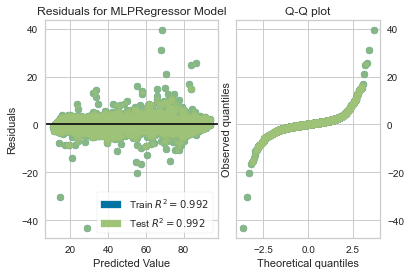

In [65]:
fig, ax = plt.subplots(figsize=(6, 4))
rpv = ResidualsPlot(mlp, hist=False, qqplot=True)
rpv.fit(X_train_scaled, y_train)
rpv.score(X_train_scaled, y_train)
rpv.poof();

In [66]:
resids = y_train - mlp.predict(X_train_scaled)
hb = sms.het_breuschpagan(resids, X_train_scaled)
labels = [
    "Lagrange multiplier statistic",
    "p-value",
    "f-value",
    "f p-value",
]
for name, num in zip(labels, hb):
    print(f"{name}: {num:.2}")

Lagrange multiplier statistic: 2.2e+01
p-value: 0.005
f-value: 2.4
f p-value: 0.0089


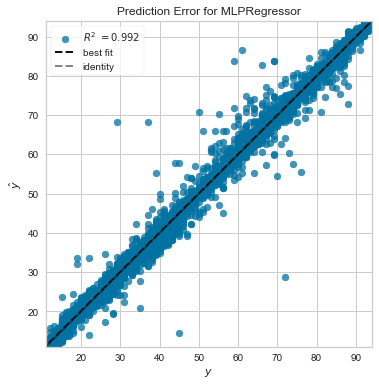

In [67]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(mlp)
pev.fit(X_train_scaled, y_train)
pev.score(X_train_scaled, y_train)
pev.poof();

In [68]:
r2 = r2_score(y_train, mlp_p)
mse = mean_squared_error(y_train, mlp_p)
rmse = mean_squared_error(y_train, mlp_p, squared=False)
mae = mean_absolute_error(y_train, mlp_p)
medae = median_absolute_error(y_train, mlp_p)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}')    

R²: 0.992
MSE: 5.159
RMSE: 2.271
MAE: 1.234
MedAE: 0.777


In [69]:
r2 = cross_val_score(mlp, X_train_scaled, y_train, cv=cvs, scoring='r2')
mse = -cross_val_score(mlp, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_squared_error')
rmse = -cross_val_score(mlp, X_train_scaled, y_train, cv=cvs, scoring='neg_root_mean_squared_error')
mae = -cross_val_score(mlp, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_absolute_error')
medae = -cross_val_score(mlp, X_train_scaled, y_train, cv=cvs, scoring='neg_median_absolute_error')

print(f'R²: {r2.mean():.3f} +- {r2.std():.3f}')
print(f'MSE: {mse.mean():.3f} +- {mse.std():.3f}')
print(f'RMSE: {rmse.mean():.3f} +- {rmse.std():.3f}')
print(f'MAE: {mae.mean():.3f} +- {mae.std():.3f}')
print(f'MedAE: {medae.mean():.3f} +- {medae.std():.3f}')

R²: 0.990 +- 0.004
MSE: 6.336 +- 2.467
RMSE: 2.477 +- 0.448
MAE: 1.363 +- 0.102
MedAE: 0.848 +- 0.058


### Avaliação Final do Modelo

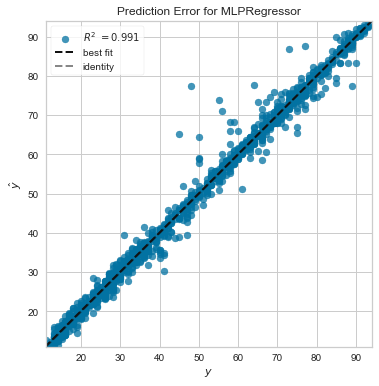

In [70]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(mlp)
pev.fit(X_train_scaled, y_train)
pev.score(X_test_scaled, y_test)
pev.poof();

In [71]:
pred_mlp = mlp.predict(X_test_scaled)

In [72]:
r2 = r2_score(y_test, pred_mlp)
mse = mean_squared_error(y_test, pred_mlp)
rmse = mean_squared_error(y_test, pred_mlp, squared=False)
mae = mean_absolute_error(y_test, pred_mlp)
medae = median_absolute_error(y_test, pred_mlp)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}')  

R²: 0.991
MSE: 5.365
RMSE: 2.316
MAE: 1.312
MedAE: 0.812


### DecisionTree Regressor

In [73]:
dtr = DecisionTreeRegressor(max_depth=2, random_state=42)
dtr.fit(X_train_scaled, y_train)
dtr_p = dtr.predict(X_train_scaled)

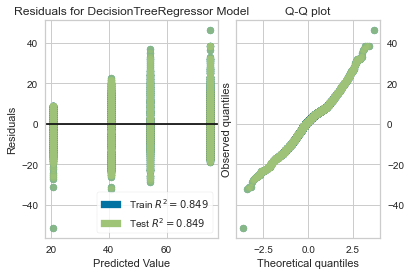

In [74]:
fig, ax = plt.subplots(figsize=(6, 4))
rpv = ResidualsPlot(dtr, hist=False, qqplot=True)
rpv.fit(X_train_scaled, y_train)
rpv.score(X_train_scaled, y_train)
rpv.poof();

In [75]:
resids = y_train - dtr.predict(X_train_scaled)
hb = sms.het_breuschpagan(resids, X_train_scaled)
labels = [
    "Lagrange multiplier statistic",
    "p-value",
    "f-value",
    "f p-value",
]
for name, num in zip(labels, hb):
    print(f"{name}: {num:.2}")

Lagrange multiplier statistic: 2.1e+02
p-value: 1.2e-41
f-value: 2.5e+01
f p-value: 8.7e-42


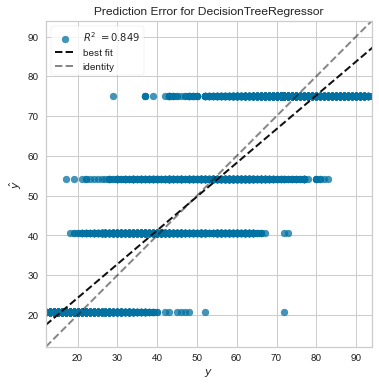

In [76]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(dtr)
pev.fit(X_train_scaled, y_train)
pev.score(X_train_scaled, y_train)
pev.poof();

In [77]:
r2 = r2_score(y_train, dtr_p)
mse = mean_squared_error(y_train, dtr_p)
rmse = mean_squared_error(y_train, dtr_p, squared=False)
mae = mean_absolute_error(y_train, dtr_p)
medae = median_absolute_error(y_train, dtr_p)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}') 

R²: 0.849
MSE: 93.526
RMSE: 9.671
MAE: 7.641
MedAE: 6.292


### Ajuste da DecisionTree

In [78]:
dtrs = DecisionTreeRegressor(random_state=42)

parameters = {
    'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth':[1, 2, 3],
    'max_features':['auto', 'sqrt', 'log2', 6, 7],
}


reg_dtr = GridSearchCV(dtrs, parameters, cv=5, scoring='neg_mean_absolute_error')
reg_dtr.fit(X_train_scaled, y_train);

In [79]:
reg_dtr.best_params_

{'criterion': 'squared_error', 'max_depth': 3, 'max_features': 'auto'}

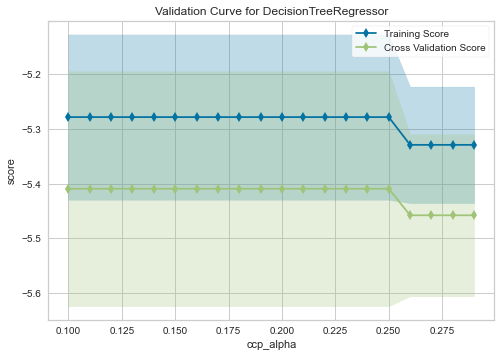

In [80]:
viz = ValidationCurve(
    DecisionTreeRegressor(criterion='absolute_error', max_depth=3, max_features='auto', random_state=42), 
    param_name='ccp_alpha',
    param_range=np.arange(0.1, 0.3, 0.01, dtype=float), 
    cv=5, 
    scoring='neg_mean_absolute_error'
)

viz.fit(X_train_scaled, y_train)
viz.show();

In [81]:
dtr_best = DecisionTreeRegressor(criterion='absolute_error', max_depth=3, max_features='auto', ccp_alpha=0.150, random_state=42)
dtr_best.fit(X_train_scaled, y_train)
dtr_p = dtr_best.predict(X_train_scaled)

In [82]:
r2 = r2_score(y_train, dtr_p)
mse = mean_squared_error(y_train, dtr_p)
rmse = mean_squared_error(y_train, dtr_p, squared=False)
mae = mean_absolute_error(y_train, dtr_p)
medae = median_absolute_error(y_train, dtr_p)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}')  

R²: 0.917
MSE: 51.054
RMSE: 7.145
MAE: 5.141
MedAE: 4.000


In [83]:
r2 = cross_val_score(dtr_best, X_train_scaled, y_train, cv=cvs, scoring='r2')
mse = -cross_val_score(dtr_best, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_squared_error')
rmse = -cross_val_score(dtr_best, X_train_scaled, y_train, cv=cvs, scoring='neg_root_mean_squared_error')
mae = -cross_val_score(dtr_best, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_absolute_error')
medae = -cross_val_score(dtr_best, X_train_scaled, y_train, cv=cvs, scoring='neg_median_absolute_error')

print(f'R²: {r2.mean():.3f} +- {r2.std():.3f}')
print(f'MSE: {mse.mean():.3f} +- {mse.std():.3f}')
print(f'RMSE: {rmse.mean():.3f} +- {rmse.std():.3f}')
print(f'MAE: {mae.mean():.3f} +- {mae.std():.3f}')
print(f'MedAE: {medae.mean():.3f} +- {medae.std():.3f}')

R²: 0.907 +- 0.006
MSE: 57.616 +- 4.020
RMSE: 7.586 +- 0.264
MAE: 5.404 +- 0.157
MedAE: 4.000 +- 0.000


### Avaliação Final do Modelo

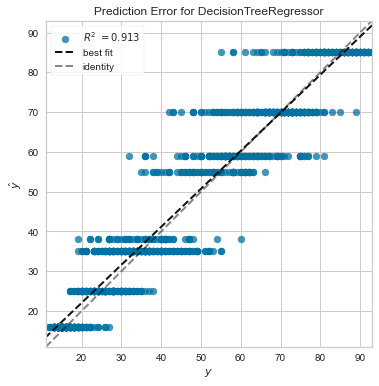

In [84]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(dtr_best)
pev.fit(X_train_scaled, y_train)
pev.score(X_test_scaled, y_test)
pev.poof();

In [85]:
pred_dtr = dtr_best.predict(X_test_scaled)

In [86]:
r2 = r2_score(y_test, pred_dtr)
mse = mean_squared_error(y_test, pred_dtr)
rmse = mean_squared_error(y_test, pred_dtr, squared=False)
mae = mean_absolute_error(y_test, pred_dtr)
medae = median_absolute_error(y_test, pred_dtr)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}')  

R²: 0.913
MSE: 50.744
RMSE: 7.123
MAE: 5.239
MedAE: 4.000


## Ensemble Regressor

### AdaBoost Regressor

In [87]:
ada = AdaBoostRegressor(random_state=42, n_estimators=100)
ada.fit(X_train_scaled, y_train);
ada_p = ada.predict(X_train_scaled)

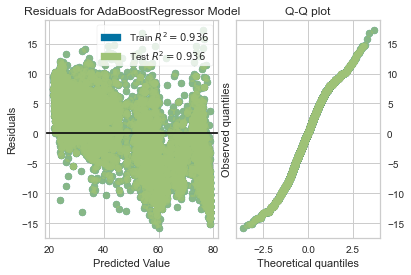

In [88]:
fig, ax = plt.subplots(figsize=(6, 4))
rpv = ResidualsPlot(ada, hist=False, qqplot=True)
rpv.fit(X_train_scaled, y_train)
rpv.score(X_train_scaled, y_train)
rpv.poof();

In [89]:
resids = y_train - ada.predict(X_train_scaled)
hb = sms.het_breuschpagan(resids, X_train_scaled)
labels = [
    "Lagrange multiplier statistic",
    "p-value",
    "f-value",
    "f p-value",
]
for name, num in zip(labels, hb):
    print(f"{name}: {num:.2}")

Lagrange multiplier statistic: 2.8e+02
p-value: 4.3e-55
f-value: 3.2e+01
f p-value: 7.5e-56


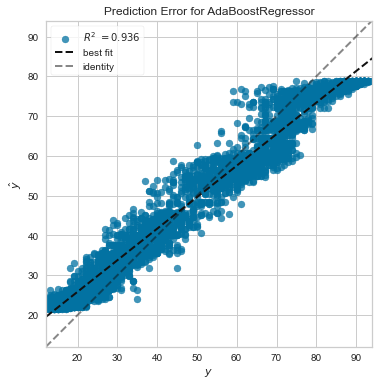

In [90]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(ada)
pev.fit(X_train_scaled, y_train)
pev.score(X_train_scaled, y_train)
pev.poof();

In [91]:
r2 = r2_score(y_train, ada_p)
mse = mean_squared_error(y_train, ada_p)
rmse = mean_squared_error(y_train, ada_p, squared=False)
mae = mean_absolute_error(y_train, ada_p)
medae = median_absolute_error(y_train, ada_p)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}') 

R²: 0.936
MSE: 39.518
RMSE: 6.286
MAE: 5.274
MedAE: 4.934


In [92]:
r2 = cross_val_score(ada, X_train_scaled, y_train, cv=cvs, scoring='r2')
mse = -cross_val_score(ada, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_squared_error')
rmse = -cross_val_score(ada, X_train_scaled, y_train, cv=cvs, scoring='neg_root_mean_squared_error')
mae = -cross_val_score(ada, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_absolute_error')
medae = -cross_val_score(ada, X_train_scaled, y_train, cv=cvs, scoring='neg_median_absolute_error')

print(f'R²: {r2.mean():.3f} +- {r2.std():.3f}')
print(f'MSE: {mse.mean():.3f} +- {mse.std():.3f}')
print(f'RMSE: {rmse.mean():.3f} +- {rmse.std():.3f}')
print(f'MAE: {mae.mean():.3f} +- {mae.std():.3f}')
print(f'MedAE: {medae.mean():.3f} +- {medae.std():.3f}')

R²: 0.937 +- 0.002
MSE: 39.249 +- 1.621
RMSE: 6.264 +- 0.130
MAE: 5.204 +- 0.145
MedAE: 4.820 +- 0.214


### Avaliação Final do Modelo

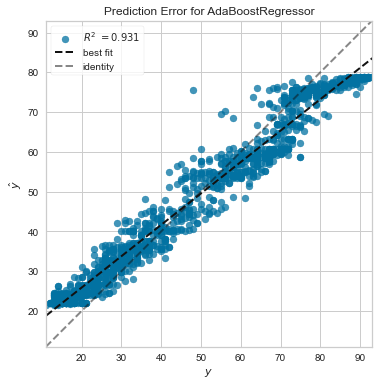

In [93]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(ada)
pev.fit(X_train_scaled, y_train)
pev.score(X_test_scaled, y_test)
pev.poof();

In [94]:
pred_ada = ada.predict(X_test_scaled)

In [95]:
r2 = r2_score(y_test, pred_ada)
mse = mean_squared_error(y_test, pred_ada)
rmse = mean_squared_error(y_test, pred_ada, squared=False)
mae = mean_absolute_error(y_test, pred_ada)
medae = median_absolute_error(y_test, pred_ada)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}') 

R²: 0.931
MSE: 39.752
RMSE: 6.305
MAE: 5.267
MedAE: 4.918


### Bagging Regressor

In [96]:
bag = BaggingRegressor(bootstrap=True, bootstrap_features=True, random_state=42, n_jobs=-1)
bag.fit(X_train_scaled, y_train)
bag_p = bag.predict(X_train_scaled)

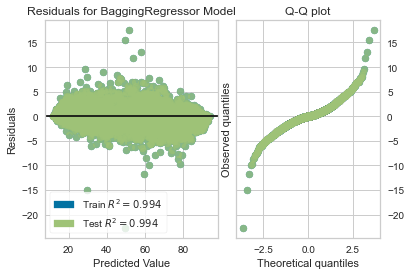

In [97]:
fig, ax = plt.subplots(figsize=(6, 4))
rpv = ResidualsPlot(bag, hist=False, qqplot=True)
rpv.fit(X_train_scaled, y_train)
rpv.score(X_train_scaled, y_train)
rpv.poof();

In [98]:
resids = y_train - bag.predict(X_train_scaled)
hb = sms.het_breuschpagan(resids, X_train_scaled)
labels = [
    "Lagrange multiplier statistic",
    "p-value",
    "f-value",
    "f p-value",
]
for name, num in zip(labels, hb):
    print(f"{name}: {num:.2}")
    

Lagrange multiplier statistic: 1.1e+02
p-value: 3e-19
f-value: 1.2e+01
f p-value: 7.2e-19


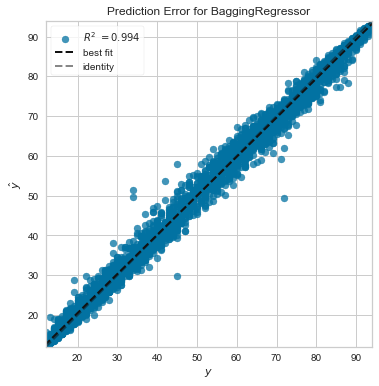

In [99]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(bag)
pev.fit(X_train_scaled, y_train)
pev.score(X_train_scaled, y_train)
pev.poof();

In [100]:
r2 = r2_score(y_train, bag_p)
mse = mean_squared_error(y_train, bag_p)
rmse = mean_squared_error(y_train, bag_p, squared=False)
mae = mean_absolute_error(y_train, bag_p)
medae = median_absolute_error(y_train, bag_p)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}') 

R²: 0.994
MSE: 3.468
RMSE: 1.862
MAE: 1.238
MedAE: 0.800


In [101]:
r2 = cross_val_score(bag, X_train_scaled, y_train, cv=cvs, scoring='r2')
mse = -cross_val_score(bag, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_squared_error')
rmse = -cross_val_score(bag, X_train_scaled, y_train, cv=cvs, scoring='neg_root_mean_squared_error')
mae = -cross_val_score(bag, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_absolute_error')
medae = -cross_val_score(bag, X_train_scaled, y_train, cv=cvs, scoring='neg_median_absolute_error')

print(f'R²: {r2.mean():.3f} +- {r2.std():.3f}')
print(f'MSE: {mse.mean():.3f} +- {mse.std():.3f}')
print(f'RMSE: {rmse.mean():.3f} +- {rmse.std():.3f}')
print(f'MAE: {mae.mean():.3f} +- {mae.std():.3f}')
print(f'MedAE: {medae.mean():.3f} +- {medae.std():.3f}')

R²: 0.975 +- 0.004
MSE: 15.528 +- 2.643
RMSE: 3.927 +- 0.328
MAE: 2.750 +- 0.103
MedAE: 1.985 +- 0.055


### Avaliação Final do Modelo

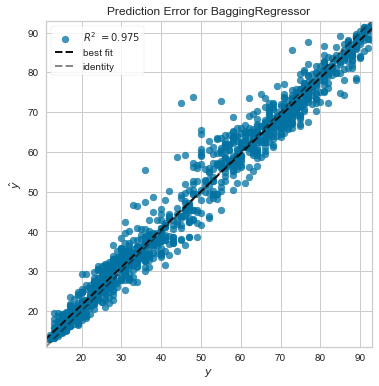

In [102]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(bag)
pev.fit(X_train_scaled, y_train)
pev.score(X_test_scaled, y_test)
pev.poof();

In [103]:
pred_bag = bag.predict(X_test_scaled)

In [104]:
r2 = r2_score(y_test, pred_bag)
mse = mean_squared_error(y_test, pred_bag)
rmse = mean_squared_error(y_test, pred_bag, squared=False)
mae = mean_absolute_error(y_test, pred_bag)
medae = median_absolute_error(y_test, pred_bag)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}') 

R²: 0.975
MSE: 14.398
RMSE: 3.795
MAE: 2.732
MedAE: 2.000


### ExtraTree Regressor

In [105]:
etr = ExtraTreesRegressor(bootstrap=True, n_jobs=-1, random_state=42)
etr.fit(X_train_scaled, y_train)
etr_p = etr.predict(X_train_scaled)

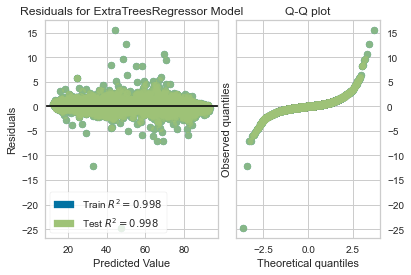

In [106]:
fig, ax = plt.subplots(figsize=(6, 4))
rpv = ResidualsPlot(etr, hist=False, qqplot=True)
rpv.fit(X_train_scaled, y_train)
rpv.score(X_train_scaled, y_train)
rpv.poof();

In [107]:
resids = y_train - etr.predict(X_train_scaled)
hb = sms.het_breuschpagan(resids, X_train_scaled)
labels = [
    "Lagrange multiplier statistic",
    "p-value",
    "f-value",
    "f p-value",
]
for name, num in zip(labels, hb):
    print(f"{name}: {num:.2}")

Lagrange multiplier statistic: 1.9e+01
p-value: 0.017
f-value: 2.1
f p-value: 0.029


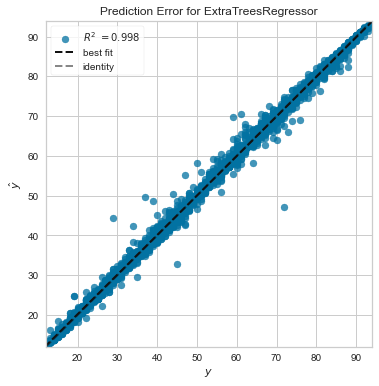

In [108]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(etr)
pev.fit(X_train_scaled, y_train)
pev.score(X_train_scaled, y_train)
pev.poof();

In [109]:
r2 = r2_score(y_train, etr_p)
mse = mean_squared_error(y_train, etr_p)
rmse = mean_squared_error(y_train, etr_p, squared=False)
mae = mean_absolute_error(y_train, etr_p)
medae = median_absolute_error(y_train, etr_p)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}') 

R²: 0.998
MSE: 1.018
RMSE: 1.009
MAE: 0.540
MedAE: 0.320


In [110]:
r2 = cross_val_score(etr, X_train_scaled, y_train, cv=cvs, scoring='r2')
mse = -cross_val_score(etr, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_squared_error')
rmse = -cross_val_score(etr, X_train_scaled, y_train, cv=cvs, scoring='neg_root_mean_squared_error')
mae = -cross_val_score(etr, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_absolute_error')
medae = -cross_val_score(etr, X_train_scaled, y_train, cv=cvs, scoring='neg_median_absolute_error')

print(f'R²: {r2.mean():.3f} +- {r2.std():.3f}')
print(f'MSE: {mse.mean():.3f} +- {mse.std():.3f}')
print(f'RMSE: {rmse.mean():.3f} +- {rmse.std():.3f}')
print(f'MAE: {mae.mean():.3f} +- {mae.std():.3f}')
print(f'MedAE: {medae.mean():.3f} +- {medae.std():.3f}')

R²: 0.989 +- 0.004
MSE: 6.724 +- 2.582
RMSE: 2.553 +- 0.451
MAE: 1.432 +- 0.101
MedAE: 0.845 +- 0.034


### Avaliação Final do Modelo

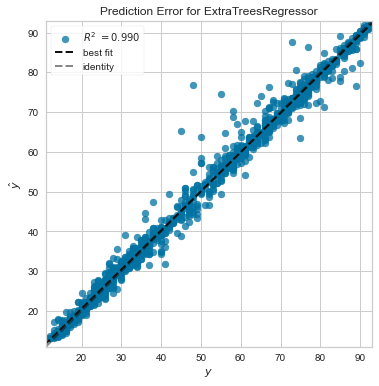

In [111]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(etr)
pev.fit(X_train_scaled, y_train)
pev.score(X_test_scaled, y_test)
pev.poof();

In [112]:
pred_etr = etr.predict(X_test_scaled)

In [113]:
r2 = r2_score(y_test, pred_etr)
mse = mean_squared_error(y_test, pred_etr)
rmse = mean_squared_error(y_test, pred_etr, squared=False)
mae = mean_absolute_error(y_test, pred_etr)
medae = median_absolute_error(y_test, pred_etr)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}') 

R²: 0.990
MSE: 5.750
RMSE: 2.398
MAE: 1.398
MedAE: 0.840


### GradientBoosting Regressor

In [114]:
gdb = GradientBoostingRegressor(random_state=42, max_depth=3)
gdb.fit(X_train_scaled, y_train)
gdb_p = gdb.predict(X_train_scaled)

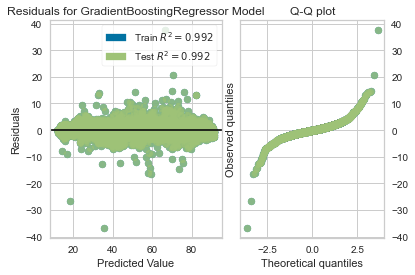

In [115]:
fig, ax = plt.subplots(figsize=(6, 4))
rpv = ResidualsPlot(gdb, hist=False, qqplot=True)
rpv.fit(X_train_scaled, y_train)
rpv.score(X_train_scaled, y_train)
rpv.poof();

In [116]:
resids = y_train - gdb.predict(X_train_scaled)
hb = sms.het_breuschpagan(resids, X_train_scaled)
labels = [
    "Lagrange multiplier statistic",
    "p-value",
    "f-value",
    "f p-value",
]
for name, num in zip(labels, hb):
    print(f"{name}: {num:.2}")

Lagrange multiplier statistic: 3.1e+01
p-value: 0.00014
f-value: 3.5
f p-value: 0.00029


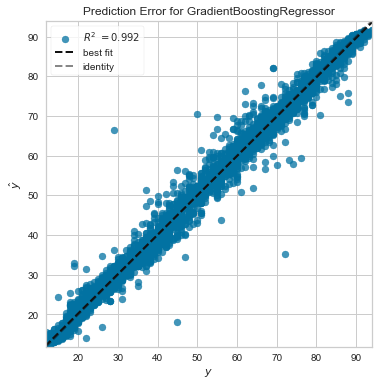

In [117]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(gdb)
pev.fit(X_train_scaled, y_train)
pev.score(X_train_scaled, y_train)
pev.poof();

In [118]:
r2 = r2_score(y_train, gdb_p)
mse = mean_squared_error(y_train, gdb_p)
rmse = mean_squared_error(y_train, gdb_p, squared=False)
mae = mean_absolute_error(y_train, gdb_p)
medae = median_absolute_error(y_train, gdb_p)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}') 

R²: 0.992
MSE: 5.223
RMSE: 2.285
MAE: 1.444
MedAE: 0.990


In [119]:
r2 = cross_val_score(gdb, X_train_scaled, y_train, cv=cvs, scoring='r2')
mse = -cross_val_score(gdb, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_squared_error')
rmse = -cross_val_score(gdb, X_train_scaled, y_train, cv=cvs, scoring='neg_root_mean_squared_error')
mae = -cross_val_score(gdb, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_absolute_error')
medae = -cross_val_score(gdb, X_train_scaled, y_train, cv=cvs, scoring='neg_median_absolute_error')

print(f'R²: {r2.mean():.3f} +- {r2.std():.3f}')
print(f'MSE: {mse.mean():.3f} +- {mse.std():.3f}')
print(f'RMSE: {rmse.mean():.3f} +- {rmse.std():.3f}')
print(f'MAE: {mae.mean():.3f} +- {mae.std():.3f}')
print(f'MedAE: {medae.mean():.3f} +- {medae.std():.3f}')

R²: 0.987 +- 0.004
MSE: 7.808 +- 2.324
RMSE: 2.767 +- 0.392
MAE: 1.674 +- 0.077
MedAE: 1.091 +- 0.041


### Avaliação Final do Modelo

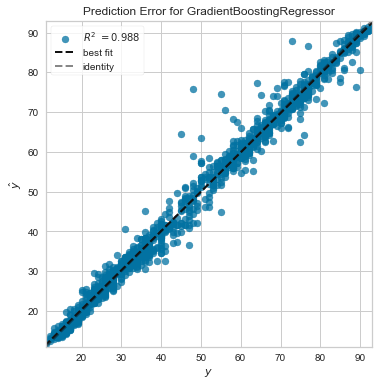

In [120]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(gdb)
pev.fit(X_train_scaled, y_train)
pev.score(X_test_scaled, y_test)
pev.poof();

In [121]:
pred_gdb = gdb.predict(X_test_scaled)

In [122]:
r2 = r2_score(y_test, pred_gdb)
mse = mean_squared_error(y_test, pred_gdb)
rmse = mean_squared_error(y_test, pred_gdb, squared=False)
mae = mean_absolute_error(y_test, pred_gdb)
medae = median_absolute_error(y_test, pred_gdb)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}') 

R²: 0.988
MSE: 6.875
RMSE: 2.622
MAE: 1.656
MedAE: 1.119


### RandomForest Regressor

In [123]:
rf = RandomForestRegressor(max_depth=3, random_state=42, bootstrap=True, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
rf_p = rf.predict(X_train_scaled)

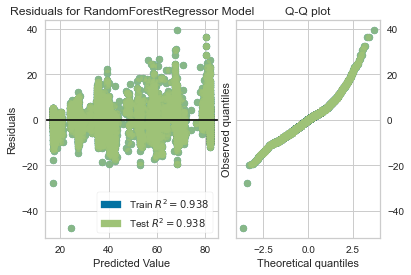

In [124]:
fig, ax = plt.subplots(figsize=(6, 4))
rpv = ResidualsPlot(rf, hist=False, qqplot=True)
rpv.fit(X_train_scaled, y_train)
rpv.score(X_train_scaled, y_train)
rpv.poof();

In [125]:
resids = y_train - rf.predict(X_train_scaled)
hb = sms.het_breuschpagan(resids, X_train_scaled)
labels = [
    "Lagrange multiplier statistic",
    "p-value",
    "f-value",
    "f p-value",
]
for name, num in zip(labels, hb):
    print(f"{name}: {num:.2}")

Lagrange multiplier statistic: 3.4e+02
p-value: 2.1e-69
f-value: 4.1e+01
f p-value: 5.3e-71


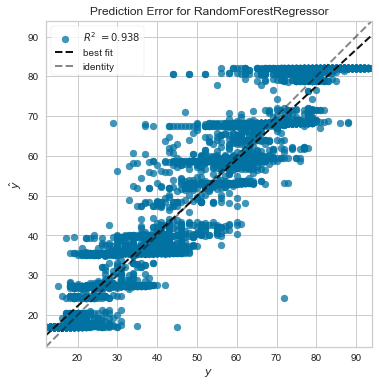

In [126]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(rf)
pev.fit(X_train_scaled, y_train)
pev.score(X_train_scaled, y_train)
pev.poof();

In [127]:
r2 = r2_score(y_train, rf_p)
mse = mean_squared_error(y_train, rf_p)
rmse = mean_squared_error(y_train, rf_p, squared=False)
mae = mean_absolute_error(y_train, rf_p)
medae = median_absolute_error(y_train, rf_p)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}') 

R²: 0.938
MSE: 38.229
RMSE: 6.183
MAE: 4.637
MedAE: 3.693


In [128]:
r2 = cross_val_score(rf, X_train_scaled, y_train, cv=cvs, scoring='r2')
mse = -cross_val_score(rf, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_squared_error')
rmse = -cross_val_score(rf, X_train_scaled, y_train, cv=cvs, scoring='neg_root_mean_squared_error')
mae = -cross_val_score(rf, X_train_scaled, y_train, cv=cvs, scoring='neg_mean_absolute_error')
medae = -cross_val_score(rf, X_train_scaled, y_train, cv=cvs, scoring='neg_median_absolute_error')

print(f'R²: {r2.mean():.3f} +- {r2.std():.3f}')
print(f'MSE: {mse.mean():.3f} +- {mse.std():.3f}')
print(f'RMSE: {rmse.mean():.3f} +- {rmse.std():.3f}')
print(f'MAE: {mae.mean():.3f} +- {mae.std():.3f}')
print(f'MedAE: {medae.mean():.3f} +- {medae.std():.3f}')

R²: 0.936 +- 0.004
MSE: 39.456 +- 2.347
RMSE: 6.279 +- 0.188
MAE: 4.708 +- 0.102
MedAE: 3.723 +- 0.097


### Avaliação Final do Modelo

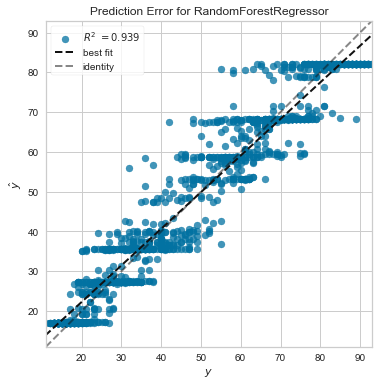

In [129]:
fig, ax = plt.subplots(figsize=(6, 6))
pev = PredictionError(rf)
pev.fit(X_train_scaled, y_train)
pev.score(X_test_scaled, y_test)
pev.poof();

In [130]:
pred_rf = rf.predict(X_test_scaled)

In [131]:
r2 = r2_score(y_test, pred_rf)
mse = mean_squared_error(y_test, pred_rf)
rmse = mean_squared_error(y_test, pred_rf, squared=False)
mae = mean_absolute_error(y_test, pred_rf)
medae = median_absolute_error(y_test, pred_rf)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MedAE: {medae:.3f}')

R²: 0.939
MSE: 35.289
RMSE: 5.940
MAE: 4.540
MedAE: 3.676


## Avaliacao Categorica para o Banco de Dados Teste

In [132]:
dic = {
    'Knn':pred_knn,
    'ElasticNet':pred_eln,
    'Linear SVR':pred_svr_l,
    'SVR':pred_svr,
    'MLP':pred_mlp,
    'DecisitonTree':pred_dtr,
    'AdaBoosting':pred_ada,
    'Bagging':pred_bag,  
    'ExtraTree':pred_etr,
    'GradientBoosting':pred_gdb,    
    'RandomForest':pred_rf,
}

In [133]:
cat_test = pd.cut(y_test,
                bins=[0, 19, 36, 51, 79, 100],
                labels=[0, 1, 2, 3, 4])

In [134]:
cat_test = cat_test.fillna(0)

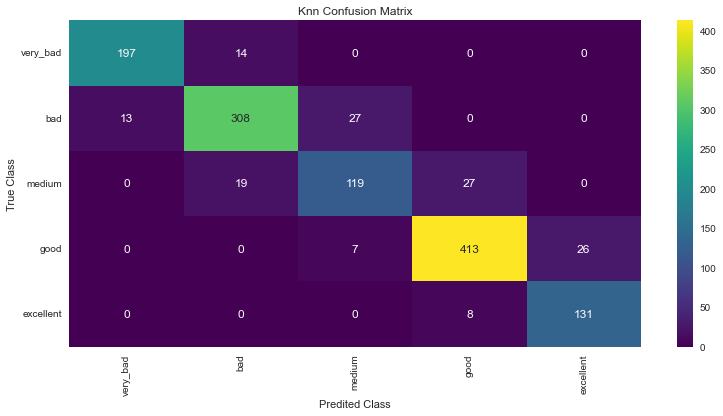

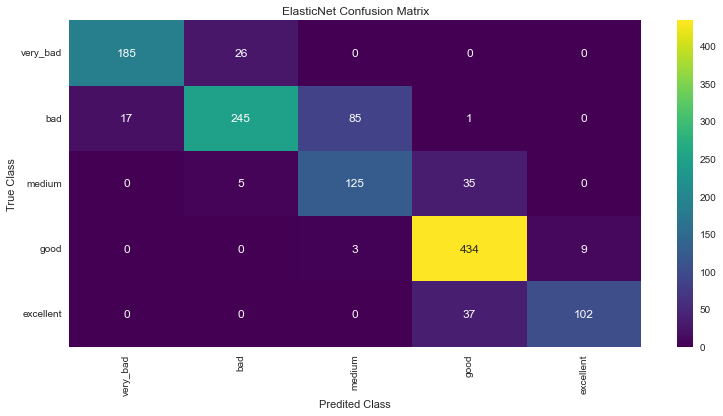

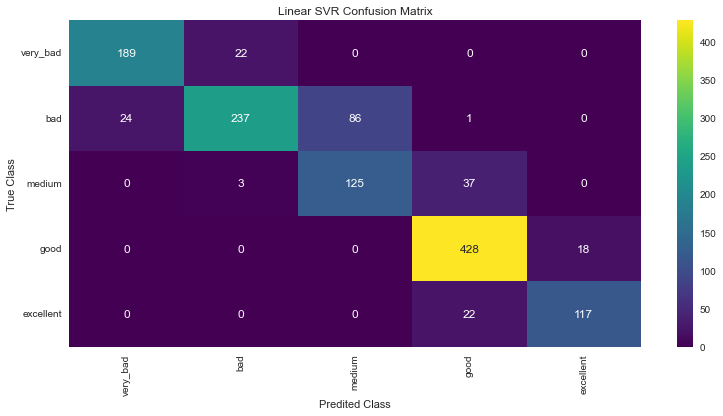

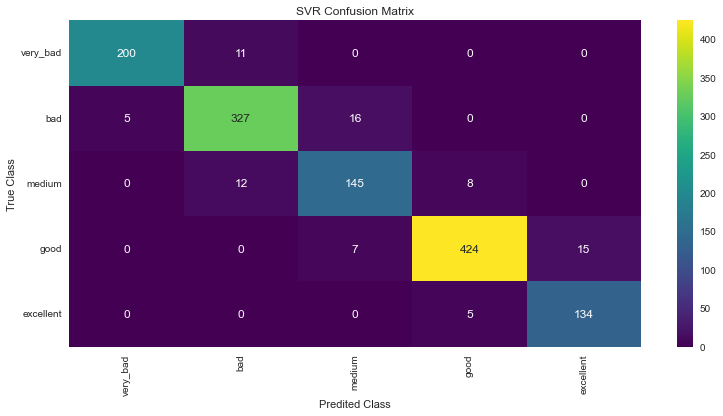

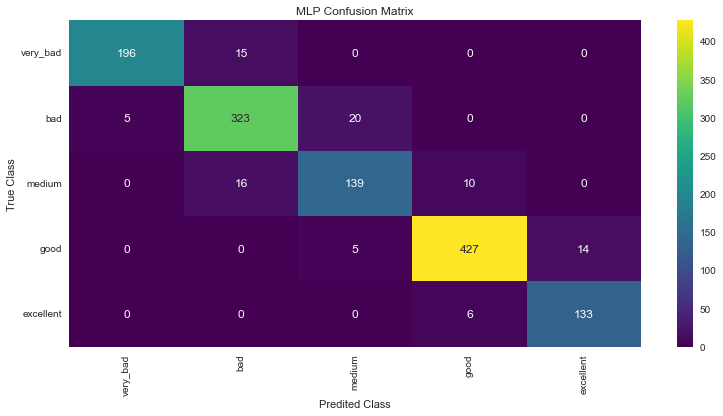

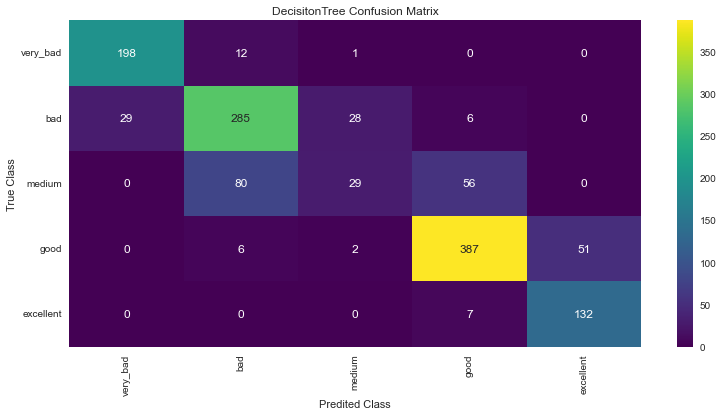

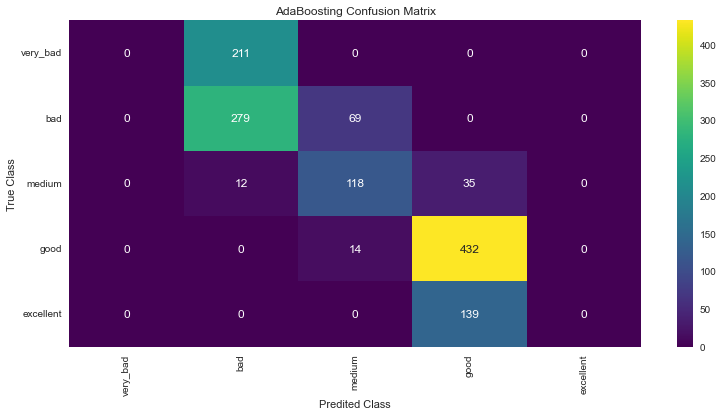

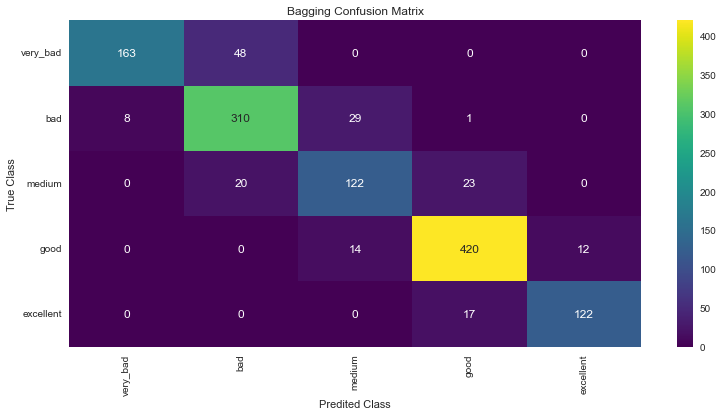

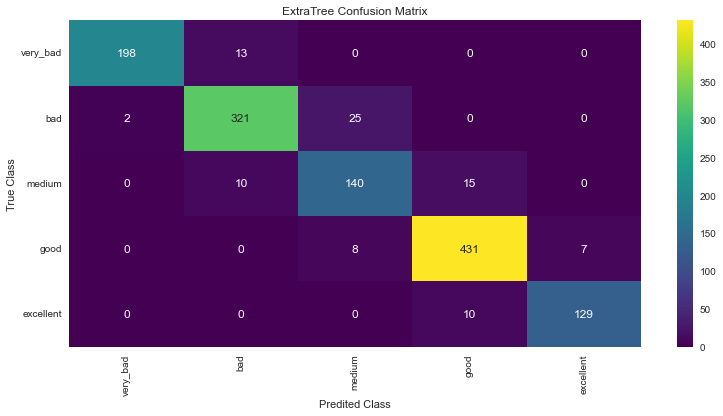

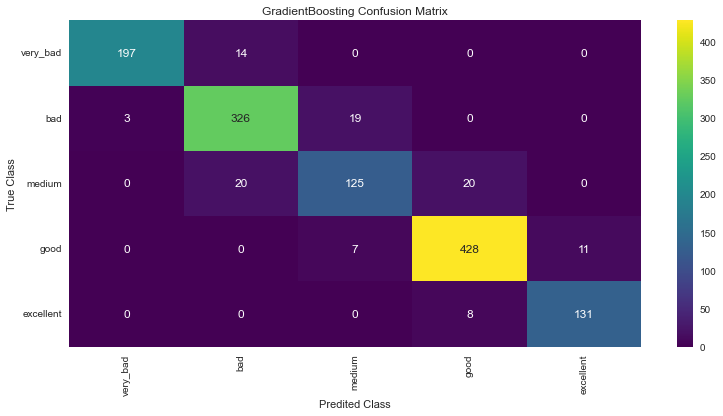

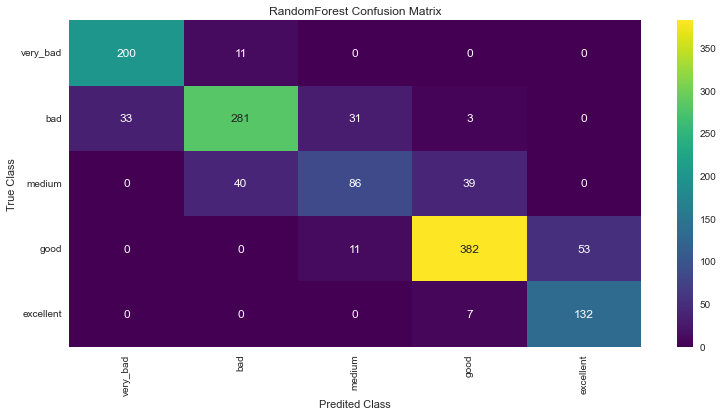

In [135]:
for n, v in enumerate(dic):
    cat_pred = pd.cut(dic[v],
                bins=[0, 19, 36, 51, 79, 100],
                labels=[0, 1, 2, 3, 4])
    cat_pred = cat_pred.fillna(0)
    matrix = confusion_matrix(cat_test, cat_pred)
    plt.figure(figsize=(12.8,6))
    ax = sns.heatmap(matrix, 
            annot=True, 
            cmap='viridis', 
            fmt='g', 
            xticklabels=['very_bad', 'bad', 'medium', 'good', 'excellent'],
            yticklabels=['very_bad', 'bad', 'medium', 'good', 'excellent'],
                )
    ax.set_xticklabels(ax.get_yticklabels(), rotation = 90)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
    plt.xlabel('Predited Class'); 
    plt.ylabel('True Class'); 
    plt.title(f'{v} Confusion Matrix');
    plt.show() 

In [136]:
for n, v in enumerate(dic):
    cat_pred = pd.cut(dic[v],
                bins=[0, 19, 36, 51, 79, 100],
                labels=[0, 1, 2, 3, 4])
    cat_pred = cat_pred.fillna(0)
    print(f'=============================================================================')
    print(f'Accuracy {v}: {balanced_accuracy_score(cat_test, cat_pred):.3f}')
    print(f'Precision {v}: {precision_score(cat_test, cat_pred, average="weighted"):.3f}')
    print(f'Recall {v}: {recall_score(cat_test, cat_pred, average="weighted"):.3f}')
    print(f'F1 {v}: {f1_score(cat_test, cat_pred, average="weighted"):.3f}')
    print(f'=============================================================================')

Accuracy Knn: 0.882
Precision Knn: 0.892
Recall Knn: 0.892
F1 Knn: 0.892
Accuracy ElasticNet: 0.809
Precision ElasticNet: 0.847
Recall ElasticNet: 0.833
F1 ElasticNet: 0.834
Accuracy Linear SVR: 0.827
Precision Linear SVR: 0.849
Recall Linear SVR: 0.837
F1 Linear SVR: 0.837
Accuracy SVR: 0.936
Precision SVR: 0.941
Recall SVR: 0.940
F1 SVR: 0.940
Accuracy MLP: 0.923
Precision MLP: 0.931
Recall MLP: 0.930
F1 MLP: 0.931
Accuracy DecisitonTree: 0.750
Precision DecisitonTree: 0.765
Recall DecisitonTree: 0.788
F1 DecisitonTree: 0.765
Accuracy AdaBoosting: 0.497
Precision AdaBoosting: 0.465
Recall AdaBoosting: 0.633
F1 AdaBoosting: 0.536
Accuracy Bagging: 0.844
Precision Bagging: 0.872
Recall Bagging: 0.869
F1 Bagging: 0.868
Accuracy ExtraTree: 0.921
Precision ExtraTree: 0.932
Recall ExtraTree: 0.931
F1 ExtraTree: 0.932
Accuracy GradientBoosting: 0.906
Precision GradientBoosting: 0.922
Recall GradientBoosting: 0.922
F1 GradientBoosting: 0.921
Accuracy RandomForest: 0.817
Precision RandomFores

## Dataset sp2019

In [137]:
lista = [
    knn,
    eln,
    svr_l,
    svr_best,
    mlp,
    dtr_best,
    ada,
    bag,
    etr,
    gdb,
    rf
]

In [138]:
for n, v in enumerate(lista):
    v.fit(X_train_scaled, y_train) 
    pred = v.predict(X_val_scaled)
    r2 = r2_score(y_val, pred)
    mse = mean_squared_error(y_val, pred)
    rmse = mean_squared_error(y_val, pred, squared=False)
    mae = mean_absolute_error(y_val, pred)
    medae = median_absolute_error(y_val, pred)
    
    print(f'=============================================================================')
    print(f'R² {v.__class__.__name__}: {r2:.3f}')
    print(f'MSE {v.__class__.__name__}: {mse:.3f}')
    print(f'RMSE {v.__class__.__name__}: {rmse:.3f}')
    print(f'MAE {v.__class__.__name__}: {mae:.3f}')
    print(f'MedAE {v.__class__.__name__}: {medae:.3f}')
    print(f'=============================================================================')

R² KNeighborsRegressor: 0.931
MSE KNeighborsRegressor: 23.326
RMSE KNeighborsRegressor: 4.830
MAE KNeighborsRegressor: 3.436
MedAE KNeighborsRegressor: 2.600
R² ElasticNetCV: 0.943
MSE ElasticNetCV: 19.089
RMSE ElasticNetCV: 4.369
MAE ElasticNetCV: 3.203
MedAE ElasticNetCV: 2.550
R² LinearSVR: 0.944
MSE LinearSVR: 18.990
RMSE LinearSVR: 4.358
MAE LinearSVR: 3.046
MedAE LinearSVR: 2.350
R² SVR: 0.986
MSE SVR: 4.809
RMSE SVR: 2.193
MAE SVR: 1.167
MedAE SVR: 0.668
R² MLPRegressor: 0.984
MSE MLPRegressor: 5.529
RMSE MLPRegressor: 2.351
MAE MLPRegressor: 1.418
MedAE MLPRegressor: 0.977
R² DecisionTreeRegressor: 0.797
MSE DecisionTreeRegressor: 68.481
RMSE DecisionTreeRegressor: 8.275
MAE DecisionTreeRegressor: 6.171
MedAE DecisionTreeRegressor: 5.000
R² AdaBoostRegressor: 0.855
MSE AdaBoostRegressor: 48.947
RMSE AdaBoostRegressor: 6.996
MAE AdaBoostRegressor: 5.752
MedAE AdaBoostRegressor: 5.108
R² BaggingRegressor: 0.944
MSE BaggingRegressor: 18.740
RMSE BaggingRegressor: 4.329
MAE Bagging

In [139]:
cat_val = pd.cut(y_val,
                bins=[0, 19, 36, 51, 79, 100],
                labels=[0, 1, 2, 3, 4])

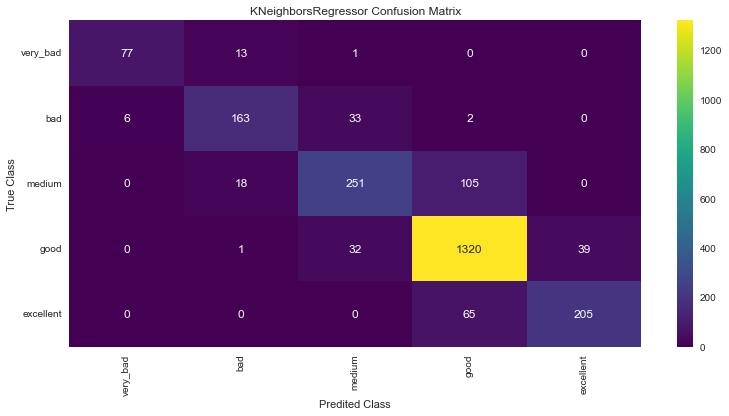

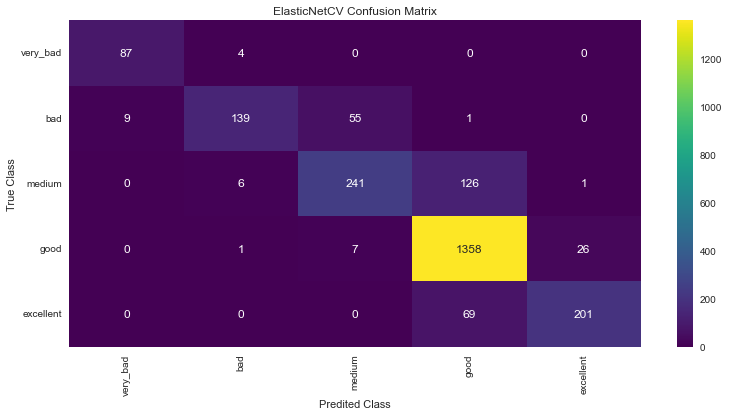

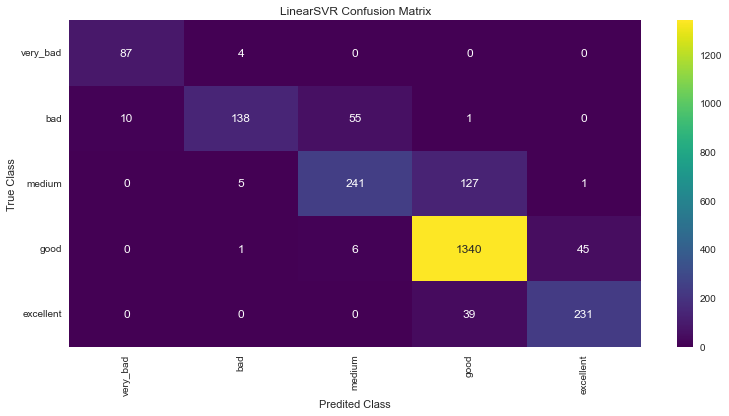

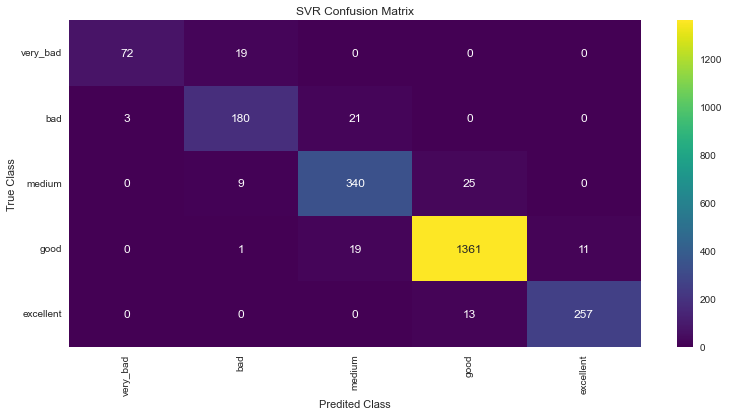

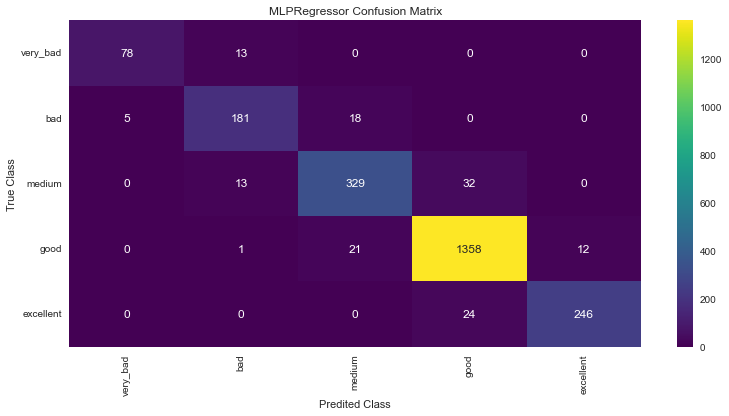

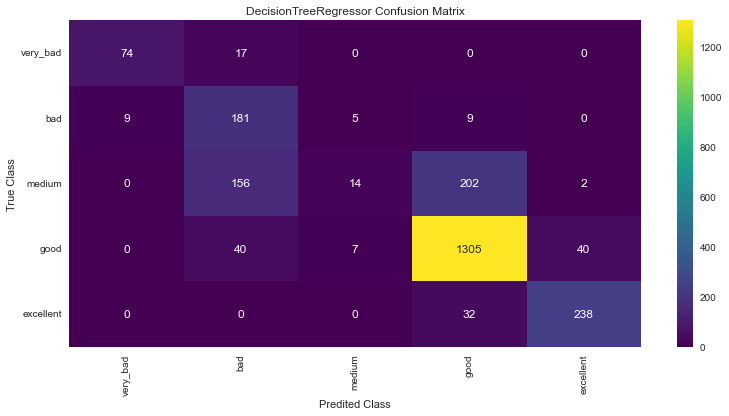

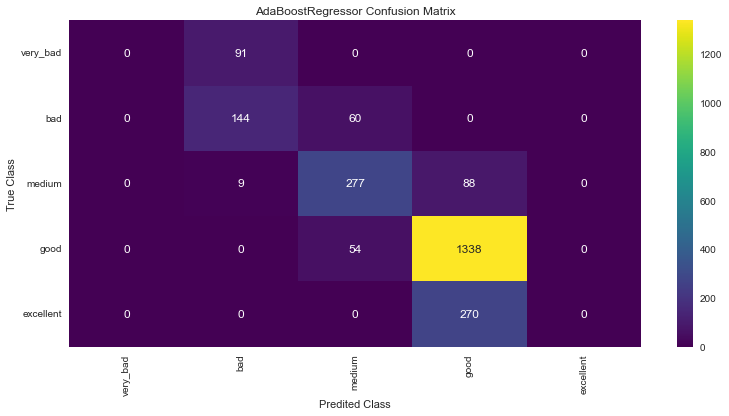

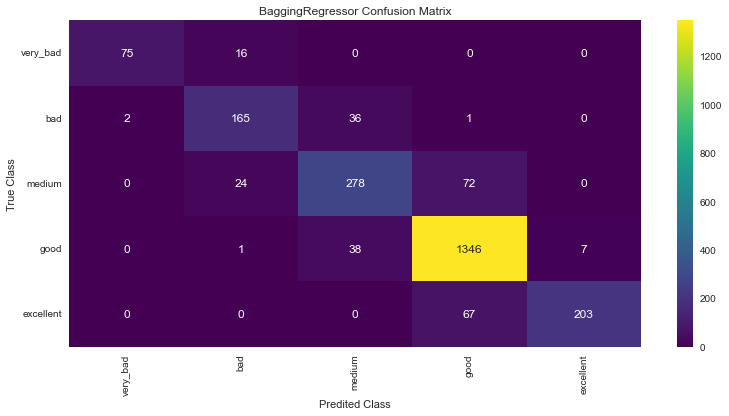

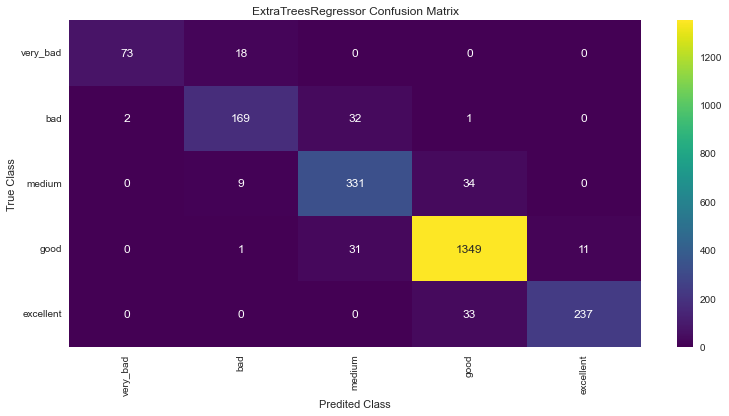

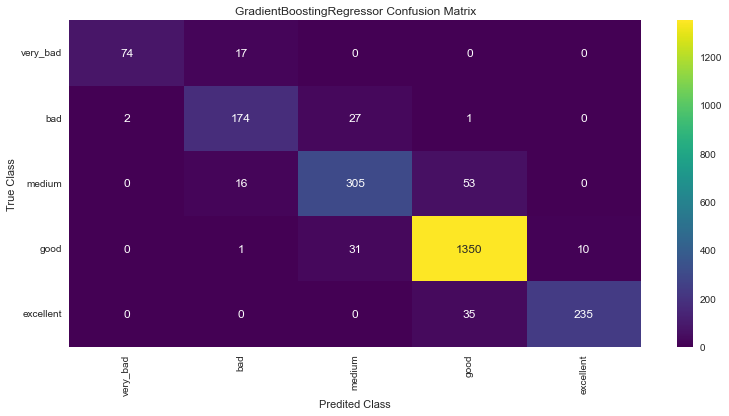

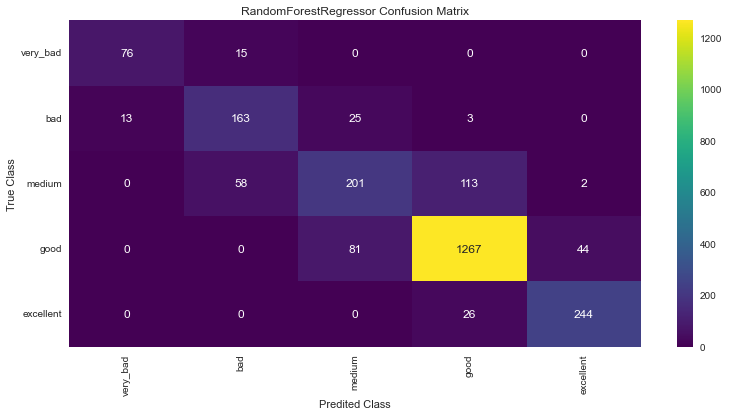

In [140]:
for n, v in enumerate(lista):
    v.fit(X_train_scaled, y_train)
    pred = v.predict(X_val_scaled)
    cat_pred = pd.cut(pred,
                bins=[0, 19, 36, 51, 79, 100],
                labels=[0, 1, 2, 3, 4])
    cat_pred  =cat_pred.fillna(0)
    matrix = confusion_matrix(cat_val, cat_pred)
    plt.figure(figsize=(12.8,6))
    ax = sns.heatmap(matrix, 
            annot=True, 
            cmap='viridis', 
            fmt='g', 
            xticklabels=['very_bad', 'bad', 'medium', 'good', 'excellent'],
            yticklabels=['very_bad', 'bad', 'medium', 'good', 'excellent'],
                )
    ax.set_xticklabels(ax.get_yticklabels(), rotation = 90)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
    plt.xlabel('Predited Class'); 
    plt.ylabel('True Class'); 
    plt.title(f'{v.__class__.__name__} Confusion Matrix');
    plt.show()

In [141]:
for n, v in enumerate(lista):
    v.fit(X_train_scaled, y_train)
    pred = v.predict(X_val_scaled)
    cat_pred = pd.cut(pred,
                bins=[0, 19, 36, 51, 79, 100],
                labels=[0, 1, 2, 3, 4])
    cat_pred = cat_pred.fillna(0)
    print(f'=============================================================================')
    print(f'Accuracy {v.__class__.__name__}: {balanced_accuracy_score(cat_val, cat_pred):.3f}')
    print(f'Precision {v.__class__.__name__}: {precision_score(cat_val, cat_pred, average="weighted"):.3f}')
    print(f'Recall {v.__class__.__name__}: {recall_score(cat_val, cat_pred, average="weighted"):.3f}')
    print(f'F1 {v.__class__.__name__}: {f1_score(cat_val, cat_pred, average="weighted"):.3f}')
    print(f'=============================================================================')

Accuracy KNeighborsRegressor: 0.805
Precision KNeighborsRegressor: 0.862
Recall KNeighborsRegressor: 0.865
F1 KNeighborsRegressor: 0.862
Accuracy ElasticNetCV: 0.800
Precision ElasticNetCV: 0.868
Recall ElasticNetCV: 0.869
F1 ElasticNetCV: 0.863
Accuracy LinearSVR: 0.819
Precision LinearSVR: 0.872
Recall LinearSVR: 0.874
F1 LinearSVR: 0.869
Accuracy SVR: 0.902
Precision SVR: 0.948
Recall SVR: 0.948
F1 SVR: 0.948
Accuracy MLPRegressor: 0.902
Precision MLPRegressor: 0.940
Recall MLPRegressor: 0.940
F1 MLPRegressor: 0.940
Accuracy DecisionTreeRegressor: 0.711
Precision DecisionTreeRegressor: 0.763
Recall DecisionTreeRegressor: 0.777
F1 DecisionTreeRegressor: 0.728
Accuracy AdaBoostRegressor: 0.482
Precision AdaBoostRegressor: 0.636
Recall AdaBoostRegressor: 0.755
F1 AdaBoostRegressor: 0.690
Accuracy BaggingRegressor: 0.819
Precision BaggingRegressor: 0.888
Recall BaggingRegressor: 0.887
F1 BaggingRegressor: 0.885
Accuracy ExtraTreesRegressor: 0.873
Precision ExtraTreesRegressor: 0.927
Rec